## EM Turkey ##
### relationship between currency rate - inflation - stockexchange ###

an attempt to use free available data sources, and to investigate if there is any predictive aspect to this


- The parameter that is lacking, is politics. (howto to quantify this?)
- There has been a sell off of foreign currency reserve by the turkish bank (not announced), howto detect?

$$\alpha\beta\gamma\Delta\Gamma$$

In [1]:
import requests     # 2.18.4
import pandas as pd # 0.23.0
import io
import datetime

In [2]:
today = datetime.datetime.now().strftime('%Y-%m-%d')
print (today)

2022-01-05


In [3]:
# Building blocks for the URL
entrypoint = 'https://sdw-wsrest.ecb.europa.eu/service/' # Using protocol 'https'
resource = 'data'           # The resource for data queries is always'data'
flowRef ='EXR'              # Dataflow describing the data that needs to be returned, exchange rates in this case
key = 'D.TRY.EUR.SP00.A'    # Defining the dimension values, explained below

# Define the parameters
parameters = {
    'startPeriod': '2021-12-01',  # Start date of the time series
#    'endPeriod': '2021-12-29'     # End of the time series
    'endPeriod': today     # End of the time series
}

In [4]:
# Construct the URL: https://sdw-wsrest.ecb.europa.eu/service/data/EXR/D.CHF.EUR.SP00.A
request_url = entrypoint + resource + '/'+ flowRef + '/' + key

# Make the HTTP request
response = requests.get(request_url, params=parameters)

# Check if the response returns succesfully with response code 200
print(response)

# Print the full URL
print(response.url)

<Response [200]>
https://sdw-wsrest.ecb.europa.eu/service/data/EXR/D.TRY.EUR.SP00.A?startPeriod=2021-12-01&endPeriod=2022-01-05


In [5]:
# Print the first 1000 characters of the response
print(response.text[0:1000])

<?xml version="1.0" encoding="UTF-8"?><message:GenericData xmlns:message="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message" xmlns:common="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:generic="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic" xsi:schemaLocation="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message https://sdw-wsrest.ecb.europa.eu:443/vocabulary/sdmx/2_1/SDMXMessage.xsd http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common https://sdw-wsrest.ecb.europa.eu:443/vocabulary/sdmx/2_1/SDMXCommon.xsd http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic https://sdw-wsrest.ecb.europa.eu:443/vocabulary/sdmx/2_1/SDMXDataGeneric.xsd">
<message:Header>
<message:ID>9cb6ad07-0faf-4300-8eb1-78d7668fd41b</message:ID>
<message:Test>false</message:Test>
<message:Prepared>2022-01-05T10:59:58.534+01:00</message:Prepared>
<message:Sender id="ECB"/>
<message:Structure structureID="

Hmmm, the response is in XML. Not impossible, but also not the easiest format to work within Pandas. Fortunately, the ECB's API lets us get the data in CSV format by specifying it in the header of the request.

In [6]:
# Make the HTTP request again, now requesting for CSV format
response = requests.get(request_url, params=parameters, headers={'Accept': 'text/csv'})
# Response succesful? (Response code 200)
print(response)

<Response [200]>


In [7]:
# Print the first 1000 characters to inspect the response
#response.text[0:1000]

In [8]:
# Read the response as a file into a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.text))

In [9]:
#df

In [10]:
# Check the DataFrame's information
#df.info()

In [11]:
# Show the last 5 entries of the DataFrame
#df.tail()

The columns we need are 'TIME_PERIOD' for the dates and 'OBS_VALUE' for the prices. Let's also do a sanity check on the prices in 'OBS_VALUE'.

In [12]:
# Inspect the prices. Do the mean, minimum and maximum make sense?
df['OBS_VALUE'].describe()

count    25.000000
mean     15.380752
std       1.712679
min      12.652500
25%      14.713200
50%      15.293700
75%      15.690800
max      20.043400
Name: OBS_VALUE, dtype: float64

In [13]:
# Create a new DataFrame called 'ts'
ts = df.filter(['TIME_PERIOD', 'OBS_VALUE'], axis=1)
# 'TIME_PERIOD' was of type 'object' (as seen in df.info). Convert it to datetime first
ts['TIME_PERIOD'] = pd.to_datetime(ts['TIME_PERIOD'])
# Set 'TIME_PERIOD' to be the index
ts = ts.set_index('TIME_PERIOD')
# Print the last 5 rows to screen
ts.tail(10)

,OBS_VALUE
TIME_PERIOD,
2021-12-22,14.0719
2021-12-23,12.6525
2021-12-24,13.2402
2021-12-27,12.8099
2021-12-28,13.3521
2021-12-29,14.1525
2021-12-30,14.7184
2021-12-31,15.2335
2022-01-03,15.0777


the spike is the FX - market is 2021-12-20 where you get	20.0434 Lira for 1 Euro.

<AxesSubplot:xlabel='TIME_PERIOD'>

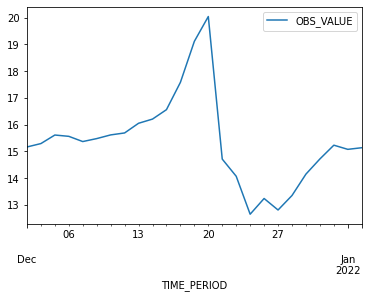

In [14]:
%matplotlib inline
ts.plot()

Turkish lira against EURO - data taken from ECB, you can see a spike at december 20th.
Subsequently there is an intervention from the Turkish national bank, supporting the Turkish lira : 
- statement by president Erdogan
- sell of foreign reserves

The new deposit scheme, called byBloomberg a rate increase in disguise, could be short-term gain and longterm pain, as the mechanism basically transfers FX risks from the private sector to the government, with the
latter guaranteeing depositor’s returns by covering any losses caused by a depreciation in the lira, as long as
those losses exceed the bank’s interest rates. This in eAect creates a liability for the government, which would
come back to bite in case the lira weakens again. To make matters worse, authorities might choose to monetize
the obligation, thus putting more pressure on inCation and the lira, creating a vicious cycle that could get out of

Summarizing, Turkey’s outlook includes more inflation, more long-term currency depreciation and no interest
rate hikes to correct these moves; on the contrary, it looks like the president will continue to blame everybody
and everything else but his beliefs. Brace yourself, Turkey.


Now we import data from the turkish stock exchange, we use the iShares MSCI Turkey.

In [15]:
import yfinance as yf

In [16]:
dft = yf.download("TUR",start='2021-12-01',end=today)
#dft.info()
dft.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-21,19.500000,19.850000,18.430000,19.379999,19.379999,2271800
2021-12-22,19.379999,19.549999,18.620001,18.980000,18.980000,557400
2021-12-23,20.799999,21.690001,20.459999,20.900000,20.900000,1899200
2021-12-27,21.799999,22.090000,21.620001,21.719999,21.719999,1162300
2021-12-28,20.700001,21.010000,20.510000,20.690001,20.690001,395300
2021-12-29,20.100000,20.410000,19.610001,20.059999,20.059999,390300
2021-12-30,19.389999,19.420000,18.660000,18.990000,18.990000,768100
2021-12-31,18.809999,18.900000,18.299999,18.580000,18.580000,790500
2022-01-03,19.309999,20.469999,19.190001,19.990000,19.990000,1607000


you can see : 2021-12-20 a	15.290000 low, which is same date as currency hike.
**hypothesis:** somebody is closely watching exchange rate on spot market and hits "sell-button" on stock-exchange?

In [17]:
#guess if you want to buy Low is more informative than high ;)
dftfil=dft.filter(['Low'])

<AxesSubplot:xlabel='Date'>

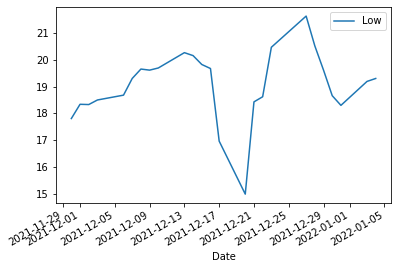

In [18]:
#%matplotlib inline
dftfil.plot()

*graph is turkish MSCI index in dollar*

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

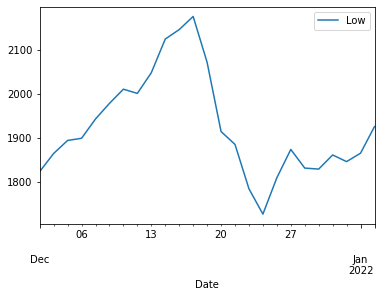

In [19]:
#istambul xu100 stock exchange price in LIRA
dftis = yf.download("XU100.IS",start='2021-12-01',end=today)
dftfilis =dftis.filter(['Low'])
dftfilis.plot()

in order to get inflation data (which is probably even higher) a technique "webscraping" is used

In [20]:
# Making a GET request
import requests  
r = requests.get('https://www.tcmb.gov.tr/wps/wcm/connect/EN/TCMB+EN/Main+Menu/Statistics/Inflation+Data/Consumer+Prices')
#r = requests.get('http://www.worldgovernmentbonds.com/bond-forecast/turkey/1-year/')
# check status code for response received
# success code - 200
print(r)
print ("test")

<Response [200]>
test


In [21]:
# print content of request
#print(r.content)
# seems unusable

Credit Default Swaps – different types
for CDS on ABS - continued
- Fixed Cap: Maximum amount that the protection seller 
has to pay buyer is the Fixed Rate
- Variable Cap: Protection seller has to make up any 
interest shortfall on the bond up to LIBOR plus the 
Fixed Rate
- No Cap: Protection seller has to make up any interest 
shortfall on the bond


*is there a way to get a headstart in information about currency : libor rate, cds ... ?*